## HDG scheme for advection-diffusion equation with upwind for advection
Contrast with Gaussian-Plume Model

In [1]:
#import netgen.gui # disable netgen gui in favor of webgui
from ngsolve import *
from netgen.geom2d import SplineGeometry
import numpy as np
import math
import time as timeit
import matplotlib.pyplot as plt

# domain geometry
geo = SplineGeometry()
length = 50
height = 20
geo.AddRectangle( (-3, 0), (length, height), bcs = ["bottom","right","top","left"])

In [30]:
def gpHDGSolver(h0=0.2, order = 2, wx=1, wy=0, xs=0, ys=1, eps = 0.2, Q=1, vis=True):
    if vis:
        from ngsolve.webgui import Draw
    t0 = timeit.time()
    mesh =  Mesh(geo.GenerateMesh(maxh=h0))
    print("ElAPSED %.2e MESH" %(timeit.time()-t0))

    # local space V, global space M for velocity
    V = L2(mesh, order=order)
    # homogeneous DBC on left
    # reasonable considering advection direction
    M = FacetFESpace(mesh, order=order, dirichlet="left|top")
    # compound finite element space
    fes = FESpace([V,M]) 
    gfu = GridFunction(fes)  # solution 
    uh,uhat = gfu.components
    
    (u,uhat), (v,vhat) = fes.TnT()  # symbolic object, test and trial ProxyFunctions
    
    # linear and bilinear forms to be specified
    a = BilinearForm(fes, condense=True)
    f1 = LinearForm(fes)
    # Dirac Delta function approximated 
    # by multivariable Gaussian
    f1 += v(xs,ys)
    
    ######## diffusion operator
    h = specialcf.mesh_size        # the local mesh size coefficient function
    n = specialcf.normal(mesh.dim) # the unit normal direction on edges
    alpha = 4 #stabilization coef
    
    jmp_u = (u-uhat)
    jmp_v = (v-vhat)
    
    eps_mat = CoefficientFunction((eps,0,0,1),dims=(2,2))
    # volume integration
    a += eps_mat*grad(u)*grad(v)*dx
    # ATTENTION: element-boundary integration
    a += (-eps_mat*grad(u)*n*jmp_v-eps_mat*grad(v)*n*jmp_u+alpha*order**2/h*eps_mat*n*n*jmp_u*jmp_v)*dx(element_boundary=True)
            
    ######## convection operator
    # velocity field
    w = CoefficientFunction((wx,wy))

    uhatup = IfPos(w*n, u, uhat) # upwinding flux
    conv = -u*w*grad(v)
    # element-boundary term 
    # ATTENTION:: a simple HACK to deactivate vhat on Neumann bdry
    neuflag = GridFunction(FacetFESpace(mesh))
    neuflag.Set(1, definedon=mesh.Boundaries("right|bottom"))
    jmp_v0 = v-vhat*(1-neuflag) 
    conv_BND =  uhatup*w*n*jmp_v0

    # convection integration
    a += conv*dx + conv_BND*dx(element_boundary=True)

    with TaskManager():
        t0=timeit.time()
        a.Assemble()
        f1.Assemble() 
        rhs = gfu.vec.CreateVector()
        rhs.data = Q*f1.vec
        print("ElAPSED %.2e ASSEMBLE" %(timeit.time()-t0))

        # add Dirichlet BC -- no need here
        #f.vec.data -= a.mat * gfu.vec
        t0=timeit.time()
        rhs.data += a.harmonic_extension_trans * rhs
        inv = a.mat.Inverse(fes.FreeDofs(True), "umfpack")
        gfu.vec.data += inv * rhs
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * rhs
        print("ElAPSED %.2e SOLVE" %(timeit.time()-t0))
        if vis:
            Draw(gfu.components[0], mesh, "uh", min=0, max=1)#, deformation=True)
    
    return mesh, fes, a, rhs, gfu


## Robustness with eps

In [33]:
gpHDGSolver(h0=0.2, order = 2, eps=1, ys= 2, wx=1, wy=0, Q=2)

ElAPSED 2.25e+00 MESH
ElAPSED 2.78e-01 ASSEMBLE
ElAPSED 1.45e+00 SOLVE


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2101-155-g55dd37409', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2…

(<ngsolve.comp.Mesh at 0x7fcd9703c9e8>,
 basevector,
 <ngsolve.comp.GridFunction at 0x7fcd979b86d0>)

## Comparison between numerical & GP of Stockie in Fig. 3.2

In [4]:
H = 0
mesh, _, _, _, gfu1 = gpHDGSolver(h0=0.2, order = 2, eps=1, ys= H, wx=1, wy=0, Q=1)

ElAPSED 2.28e+00 MESH
ElAPSED 2.47e-01 ASSEMBLE
ElAPSED 1.48e+00 SOLVE


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2101-155-g55dd37409', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2…

### When H=0

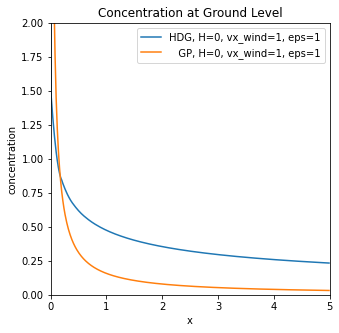

In [5]:
import scipy.io as spio
mat = spio.loadmat('matlabCode_stockie/GPH0U1.mat',squeeze_me=True)
anaSln = mat['cc']

x = [0.01*i for i in range(length*10)]
u_numerical1 = [gfu1.components[0](mesh(p, 0.0)) for p in x]

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Concentration at Ground Level")
ax.plot(x, u_numerical1, linewidth=1.5, label='HDG, H=0, vx_wind=1, eps=1')
ax.plot(x, anaSln, linewidth=1.5, label='   GP, H=0, vx_wind=1, eps=1')
ax.set_xlim([0,5])
ax.set_ylim([0,2])
ax.set_xlabel("x")
ax.set_ylabel("concentration")

ax.legend(loc='best')

In [6]:
H = 2
mesh, _, _, _, gfu1 = gpHDGSolver(h0=0.2, order = 2, eps=1, ys= H, wx=1, wy=0, Q=1)

ElAPSED 2.26e+00 MESH
ElAPSED 2.38e-01 ASSEMBLE
ElAPSED 1.47e+00 SOLVE


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2101-155-g55dd37409', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2…

### When H=2

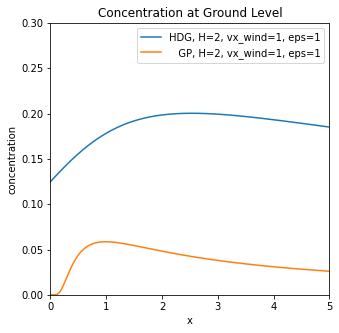

In [7]:
mat = spio.loadmat('matlabCode_stockie/GPH2U1.mat',squeeze_me=True)
anaSln = mat['cc']

x = [0.01*i for i in range(length*10)]
u_numerical1 = [gfu1.components[0](mesh(p, 0.0)) for p in x]

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Concentration at Ground Level")
ax.plot(x, u_numerical1, linewidth=1.5, label='HDG, H=2, vx_wind=1, eps=1')
ax.plot(x, anaSln, linewidth=1.5, label='   GP, H=2, vx_wind=1, eps=1')
ax.set_xlim([0,5])
ax.set_ylim([0,0.3])
ax.set_xlabel("x")
ax.set_ylabel("concentration")

ax.legend(loc='best')

## Zero flux at ground level

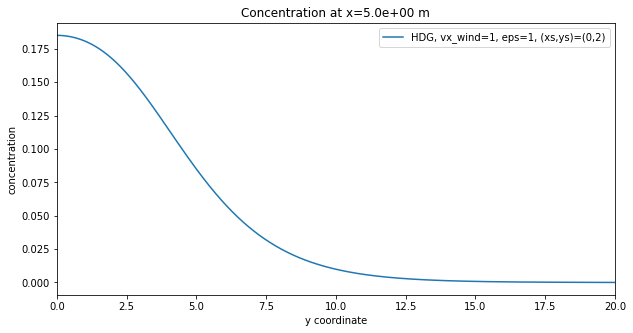

In [8]:
x = 5
y = [0.01*i for i in range(height*100)]
u_numerical = [gfu1.components[0](mesh(x, p)) for p in y]

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Concentration at x=%.1e m"%(x))
ax.plot(y, u_numerical, linewidth=1.5, label='HDG, vx_wind=1, eps=1, (xs,ys)=(0,2)')
ax.set_xlim([0,height])
ax.set_xlabel("y coordinate")
ax.set_ylabel("concentration")
ax.legend()